<a href="https://colab.research.google.com/github/Ankit-dev-ui/plant-disease-detection-modal/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup and Dataset Preparation
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

!unzip /content/dataset.zip

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

!pip install split-folders
import splitfolders
splitfolders.ratio('/content/Plant_leave_diseases_dataset_with_augmentation', output="dataset", seed=1337, ratio=(.8, .1, .1))


Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1327).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1328).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1329).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (133).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1330).JPG  
  infl

Copying files: 61486 files [00:09, 6573.27 files/s]


In [ ]:
# Dataset Loading
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"
#data preprocessing
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

class_names = train_dataset.class_names

Found 49179 files belonging to 39 classes.
Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


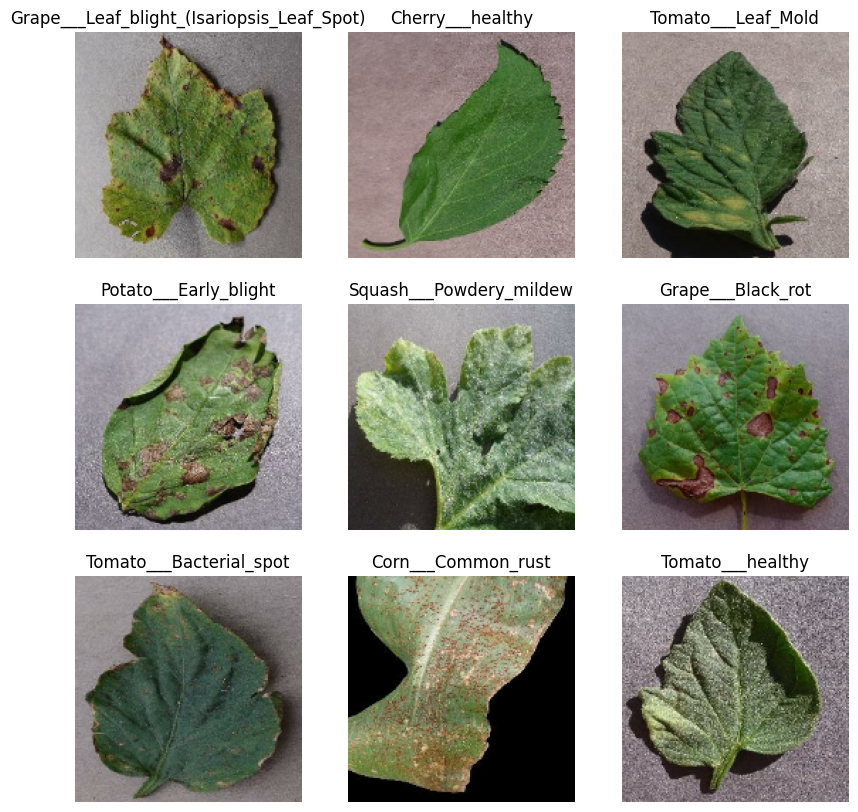

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input             # Rescales pixel values from [0, 255] to [-1, 1]


In [ ]:
# Model Building with MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Initial Training
initial_epochs = 6
loss0, accuracy0 = model.evaluate(validation_dataset)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.0429 - loss: 4.2485
Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.7838 - loss: 0.8155 - val_accuracy: 0.9433 - val_loss: 0.1816
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 64s 28ms/step - accuracy: 0.9434 - loss: 0.1773 - val_accuracy: 0.9505 - val_loss: 0.1526
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9561 - loss: 0.1337 - val_accuracy: 0.9619 - val_loss: 0.1227
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9610 - loss: 0.1149 - val_accuracy: 0.9624 - val_loss: 0.1169
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9624 - loss: 0.1065 - val_accuracy: 0.9532 - val_loss: 0.1473
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9672 - loss: 0.0938 - val_accuracy: 0.9578 - val_loss: 0.1382


In [ ]:
#  Fine-Tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 6/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 96s 41ms/step - accuracy: 0.7194 - loss: 1.7484 - val_accuracy: 0.9541 - val_loss: 0.1449
Epoch 7/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 112s 35ms/step - accuracy: 0.9449 - loss: 0.1676 - val_accuracy: 0.9677 - val_loss: 0.1075
Epoch 8/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - accuracy: 0.9654 - loss: 0.1038 - val_accuracy: 0.9725 - val_loss: 0.0861
Epoch 9/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.9777 - loss: 0.0690 - val_accuracy: 0.9772 - val_loss: 0.0743
Epoch 10/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 74s 30ms/step - accuracy: 0.9823 - loss: 0.0534 - val_accuracy: 0.9783 - val_loss: 0.0704
Epoch 11/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.9876 - loss: 0.0345 - val_accuracy: 0.9796 - val_loss: 0.0638
Epoch 12/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - accuracy: 0.9909 - loss: 0.0270 - val_accuracy: 0.9826 - val_loss: 0.0583
Epoch 13/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.9

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Metrics: Confusion Matrix, Classification Report, ROC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Get predictions
y_true = []
y_pred = []
y_score = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_score.extend(preds)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)


193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9880 - loss: 0.0358
Test accuracy : 0.9871919751167297
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━

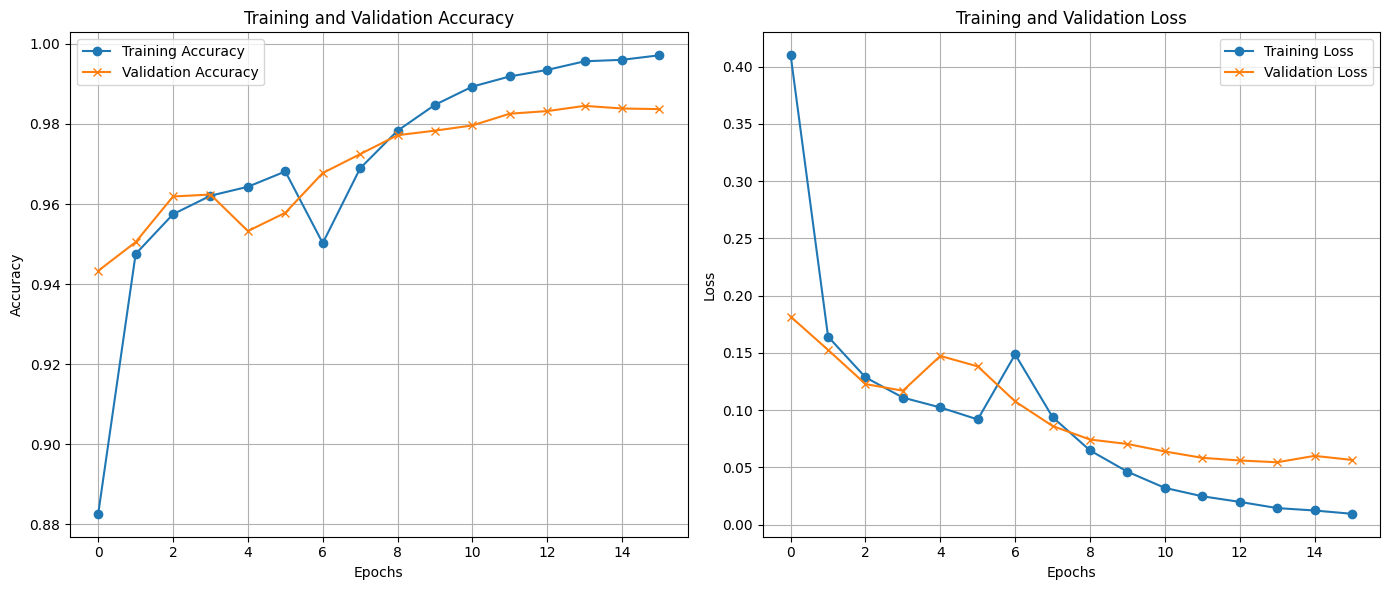

In [ ]:
# Training & Validation Graphs
acc = history.history['accuracy'] + history_fine.history['accuracy'][1:]
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy'][1:]

loss = history.history['loss'] + history_fine.history['loss'][1:]
val_loss = history.history['val_loss'] + history_fine.history['val_loss'][1:]

epochs_range = range(len(acc))  # or use total_epochs - 1

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


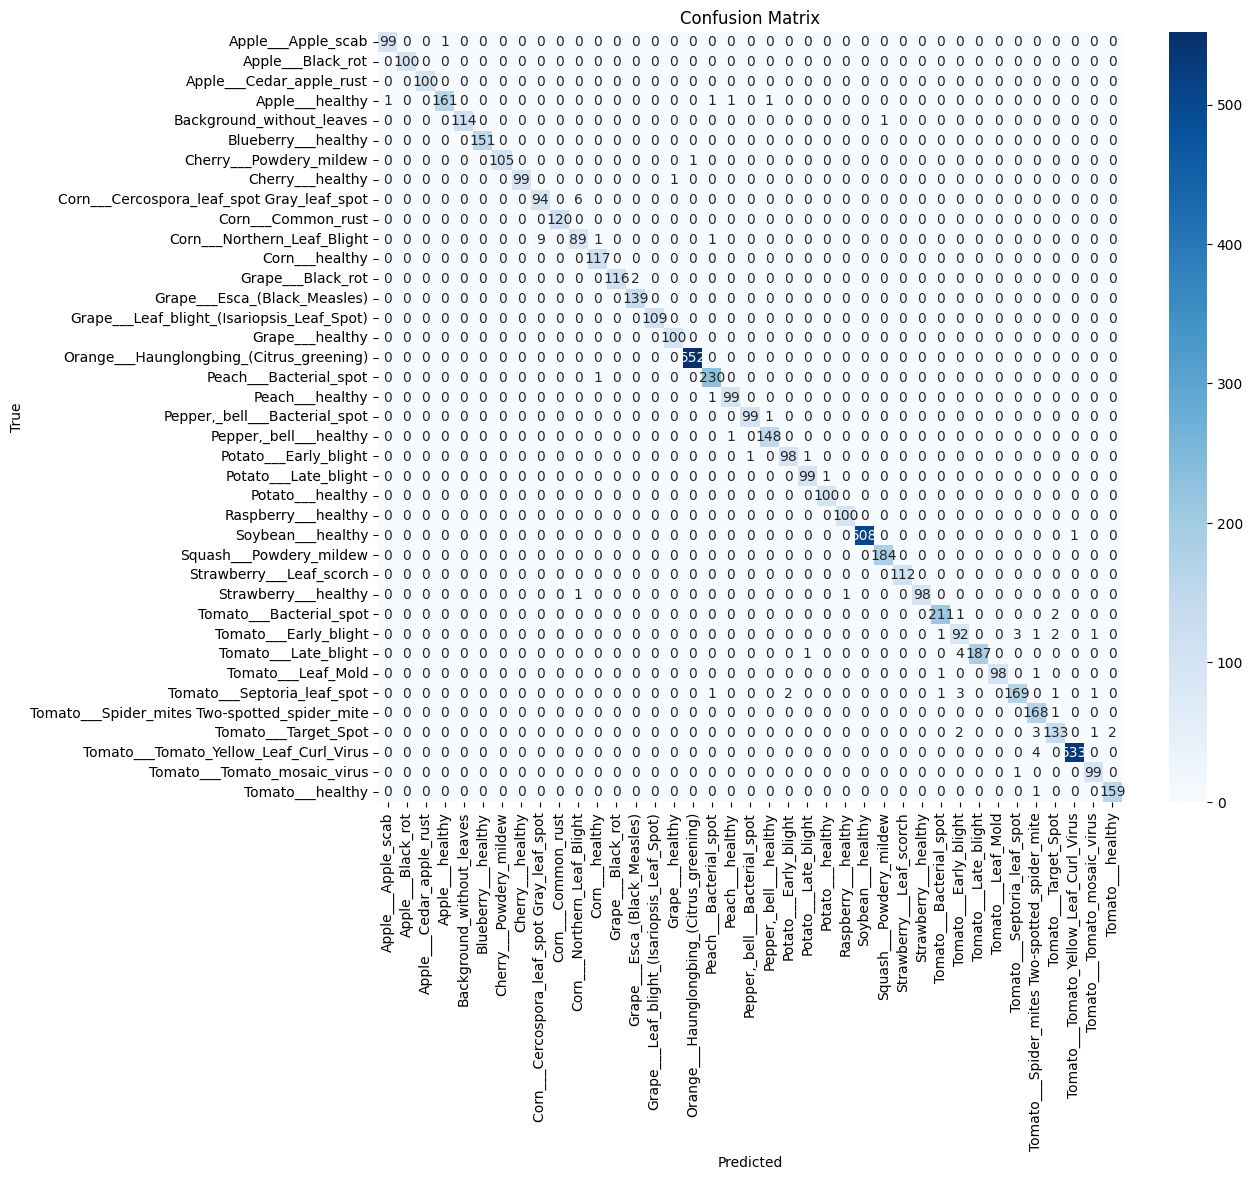

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Classification Report:

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.99      0.99       100
                            Apple___Black_rot       1.00      1.00      1.00       100
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       100
                              Apple___healthy       0.99      0.98      0.98       165
                    Background_without_leaves       1.00      0.99      1.00       115
                          Blueberry___healthy       1.00      1.00      1.00       151
                      Cherry___Powdery_mildew       1.00      0.99      1.00       106
                             Cherry___healthy       1.00      0.99      0.99       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.94      0.93       100
                           Corn___Common_rust       1.00      1.00      1.00       120
                  

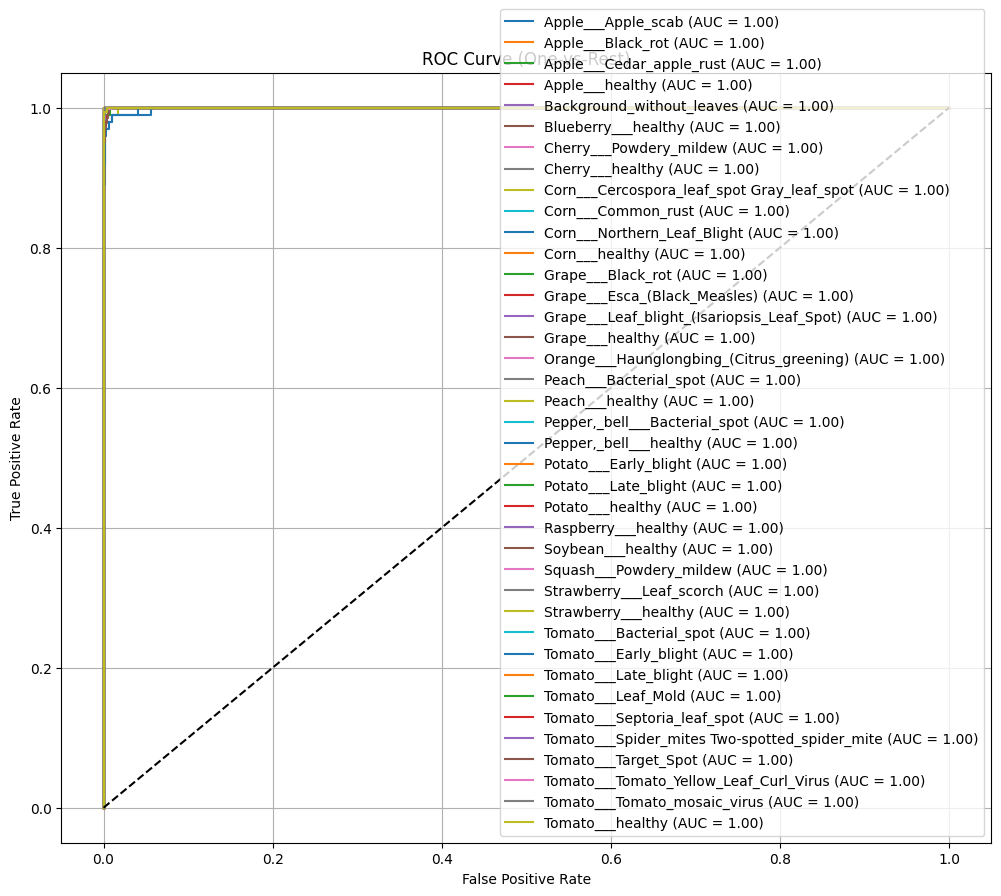

In [ ]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

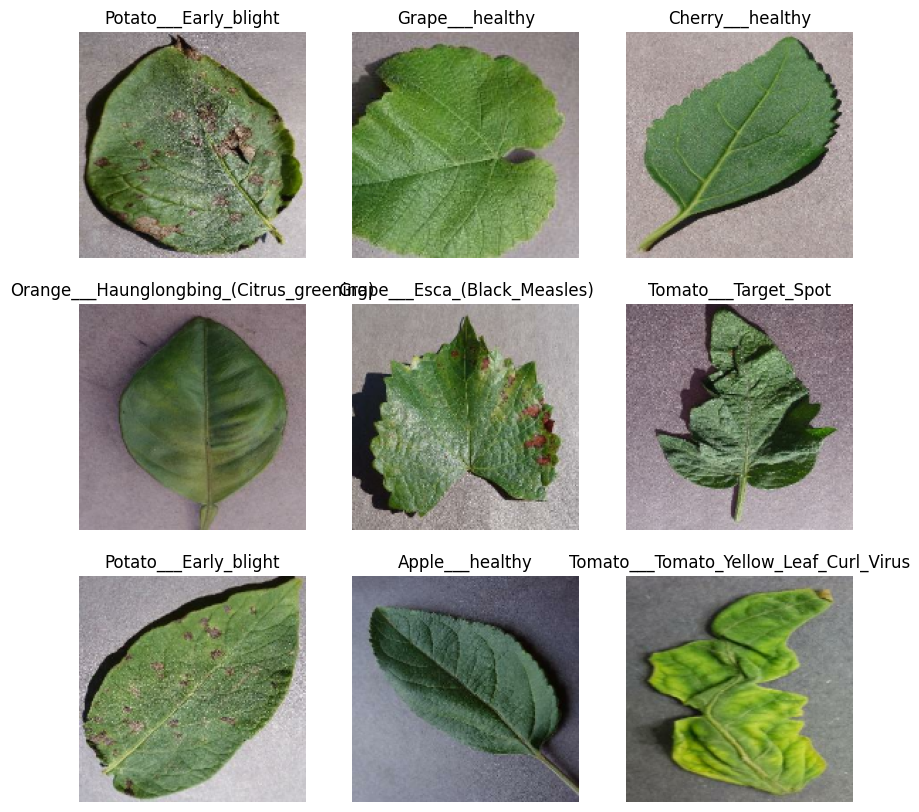

In [ ]:
# Visualize Predictions
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Predicted class: Early Blight
True class index 16 is invalid


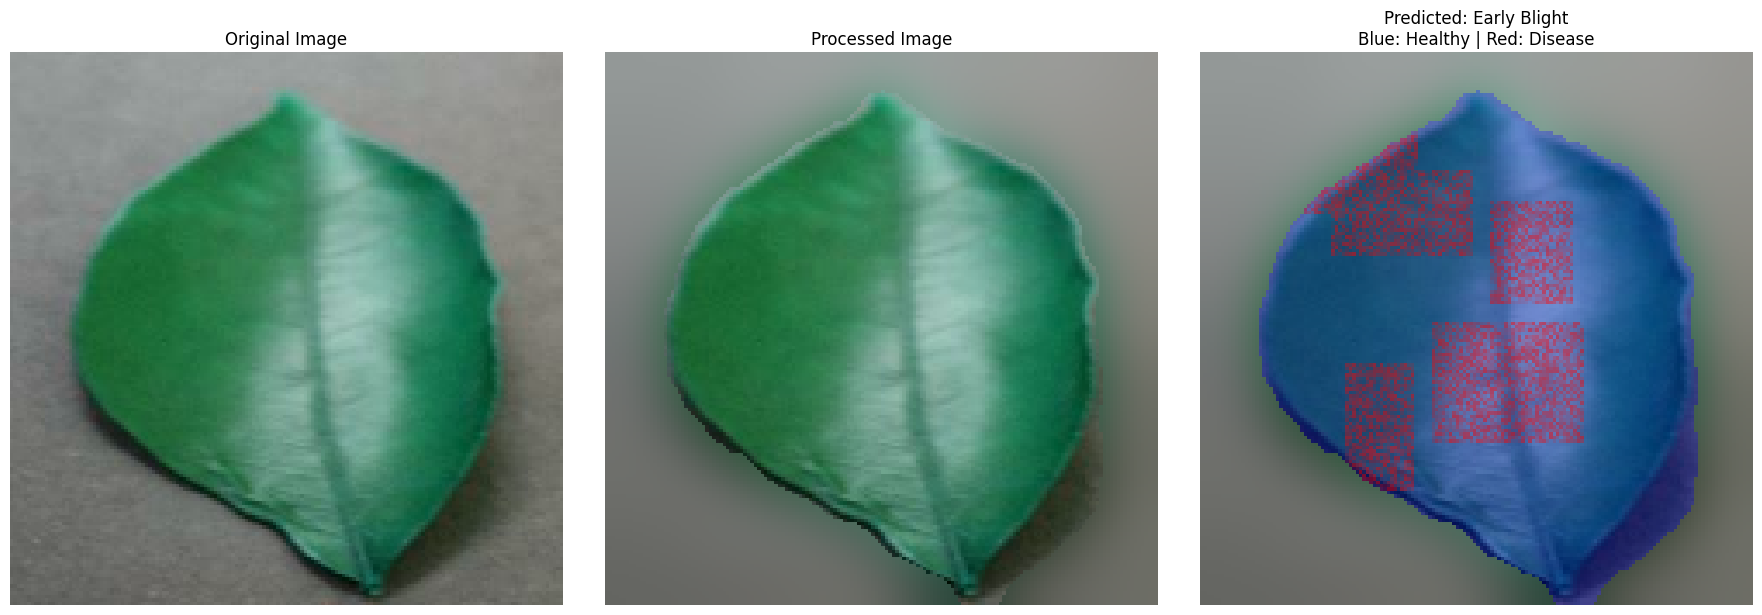

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

# Step 0: Create and initialize a dummy model properly
def create_dummy_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Initialize the model by calling it once
    dummy_input = tf.random.normal([1, 160, 160, 3])
    _ = model(dummy_input)
    return model

model = create_dummy_model()
class_names = ['Healthy', 'Early Blight', 'Late Blight']

# Step 1: Get test image
def get_test_image():
    try:
        image_batch, label_batch = test_dataset.as_numpy_iterator().next()
        return image_batch[0].astype("uint8"), label_batch[0]
    except NameError:
        print("Using sample image")
        img_url = "https://earthsally.com/wp-content/uploads/2021/03/powdery-mildew-plant-disease.jpg"
        img = io.imread(img_url)
        return img, 1  # Default to class 1

original_img, true_label = get_test_image()

# Step 2: Process image with background blur
def process_image(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img, np.zeros_like(mask)

    largest_contour = max(contours, key=cv2.contourArea)
    leaf_mask = np.zeros_like(mask)
    cv2.drawContours(leaf_mask, [largest_contour], -1, 255, -1)

    isolated = cv2.bitwise_and(img, img, mask=leaf_mask)
    blurred_bg = cv2.GaussianBlur(img, (51, 51), 0)
    blurred_bg = cv2.bitwise_and(blurred_bg, blurred_bg, mask=255-leaf_mask)
    return cv2.add(isolated, blurred_bg), leaf_mask

processed_img, leaf_mask = process_image(original_img)

# Step 3: Predict with the model (with @tf.function to prevent retracing)
@tf.function(reduce_retracing=True)
def predict(model, x):
    return model(x)

leaf_resized = tf.image.resize(processed_img, (160, 160))
input_arr = tf.expand_dims(leaf_resized, axis=0)
input_arr = tf.cast(input_arr, tf.float32) / 255.0

prediction = predict(model, input_arr)
predicted_class_idx = int(tf.argmax(prediction[0]).numpy())
predicted_class_name = class_names[predicted_class_idx]
print("\nPredicted class:", predicted_class_name)

try:
    print("True class:", class_names[true_label])
except (IndexError, TypeError):
    print(f"True class index {true_label} is invalid")

# Step 4: Improved visualization function
def simple_disease_visualization(img, mask):
    # Convert to float32 for calculations
    img = img.astype(np.float32) / 255.0
    mask = mask.astype(np.float32) / 255.0

    # Create disease mask (random for demo)
    disease_mask = np.zeros_like(mask)
    height, width = mask.shape

    # Add random disease patches only where leaf exists
    for _ in range(5):
        x, y = np.random.randint(0, width-50), np.random.randint(0, height-50)
        w, h = np.random.randint(20, 50), np.random.randint(20, 50)
        patch_mask = mask[y:y+h, x:x+w]
        disease_mask[y:y+h, x:x+w] = np.random.random(patch_mask.shape) * patch_mask

    # Create colored overlays
    healthy_blue = np.zeros_like(img)
    healthy_blue[..., 0] = 1  # Blue channel

    disease_red = np.zeros_like(img)
    disease_red[..., 2] = 1  # Red channel

    # Apply overlays
    result = img.copy()
    result = result * (1 - 0.3 * mask[..., np.newaxis]) + healthy_blue * 0.3 * mask[..., np.newaxis]
    result = result * (1 - 0.5 * disease_mask[..., np.newaxis]) + disease_red * 0.5 * disease_mask[..., np.newaxis]

    return (np.clip(result, 0, 1) * 255).astype(np.uint8)

# Create and display visualizations
disease_viz = simple_disease_visualization(processed_img, leaf_mask)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title("Processed Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(disease_viz, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_class_name}\nBlue: Healthy | Red: Disease")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 9. Save Model
model.save("plant_disease_recog_mobilenetv2.keras")
model.save("/content/drive/MyDrive/plant_disease_recog_mobilenetv2.keras")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/plant_disease_recog_mobilenetv2.keras'